### Dataset: 
- head of C.elegans worm with GCAMP6 expressed in neurons. 
- imaged with light-sheeet microscope (daoSPIM) from two orthogonal directions, at 45 deg to the worm body axis.
- original images are highly anisotropic in Z vs XY. Resampled in simpleITK for isotropic resolution.
- unsheared using simpleITK.
- views are roughly registered using a rigid transformation
- views do not fully overlap with each other (left side of view0 is not in view1)

### Goal:
- fine-tune the rigid registration using affine and non-rigid methods.

### Registration flow
We register in three steps:
- Basic initialization, centering the two volumes.
- Affine registration, global non rigid transformation.
- FFD transformation, local non rigid transformation

In [1]:
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import util
import registration_callbacks
import os
from IPython.display import display, HTML 

In [2]:
dirname_data = './datasets/2019-03-05/'

### Load the images

In [3]:
view0 = sitk.ReadImage(os.path.normpath(dirname_data + 'head_view0_cropped.mhd'))
view1 = sitk.ReadImage(os.path.normpath(dirname_data + 'head_view1_cropped.mhd'))

Voxel size, um: (0.14625, 0.14625, 0.14625)
View0 size, px: (762, 140, 177)
View1 size, px: (762, 140, 177)
(73.0, 2375.0)
(0.0, 2583.0)


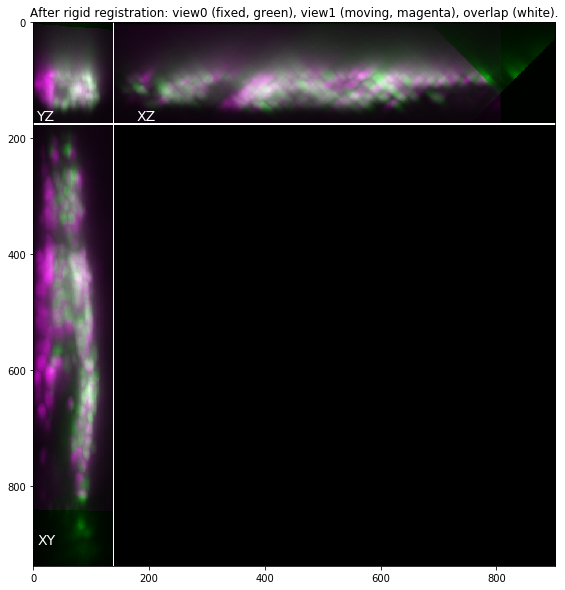

In [4]:
print(f"Voxel size, um: {view0.GetSpacing()}")

print(f"View0 size, px: {view0.GetSize()}")
print(f"View1 size, px: {view1.GetSize()}")

print(util.get_minmax(view0))
print(util.get_minmax(view1))

img_merge = util.merge_images_rgb(view0, view1)

fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "After rigid registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).")

In [5]:
fixed_image = sitk.Cast(view0, sitk.sitkFloat32)
moving_image = sitk.Cast(view1, sitk.sitkFloat32)

### Initialization

In [15]:
global_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.AffineTransform(3), 
                                                     sitk.CenteredTransformInitializerFilter.GEOMETRY)

### Affine registration
We use a single level, no need for pyramid (Occam's razor - simplest solution is preferred). We also do the registration in place, the transform variable is just updated.

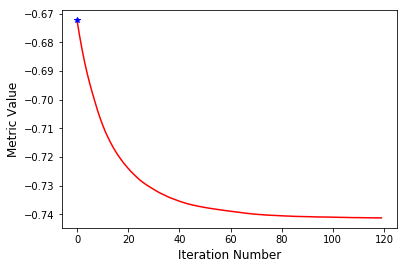

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 120.
Final metric value: -0.7412056426044382


In [16]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=300)
# Scale the step size differently for each parameter, this is critical!!!
registration_method.SetOptimizerScalesFromPhysicalShift() 

registration_method.SetInitialTransform(global_transform, inPlace=True)

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                              registration_callbacks.metric_update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, 
                              lambda: registration_callbacks.metric_plot_values(registration_method))

registration_method.Execute(fixed=fixed_image, moving=moving_image)
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

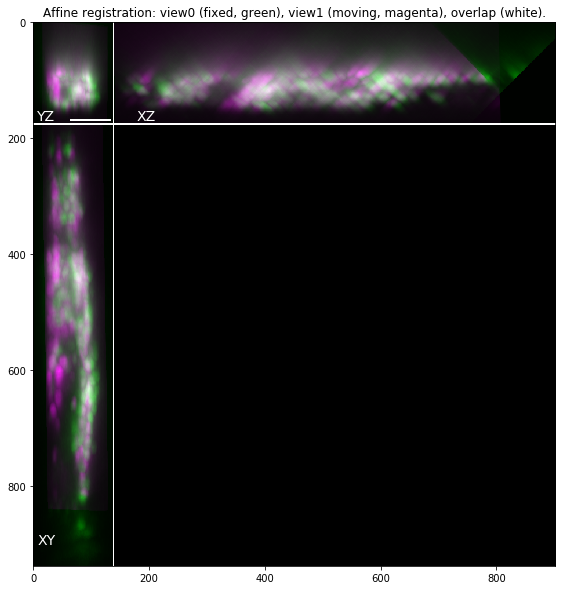

In [23]:
view1_affine = sitk.Resample(view1, view0, global_transform, sitk.sitkLinear, 0.0, view0.GetPixelID())
img_merge = util.merge_images_rgb(view0, view1_affine)

fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "Affine registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).", scalebar=10)

In [18]:
print(global_transform)

itk::simple::Transform
 AffineTransform (00000154996B7AF0)
   RTTI typeinfo:   class itk::AffineTransform<double,3>
   Reference Count: 2
   Modified Time: 1744189
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1.00391 -0.00178005 -0.0217238 
     -0.0208893 1.34877 -0.00553855 
     0.0121851 -0.0513877 0.959984 
   Offset: [-0.395462, -4.90532, -0.320862]
   Center: [88.5544, 17.1844, -10.3028]
   Translation: [0.143932, -0.704788, 0.28739]
   Inverse: 
     0.995878 0.00217342 0.0225486 
     0.0153753 0.741616 0.00462663 
     -0.0118176 0.0396709 1.04165 
   Singular: 0



The diagonal coefficients of `Matrix` which differ from 1 indicate that the affine transformation significantly scaled the image, by 1.34877 in Y and 0.959984 in Z. This can lead to over-fitting if the two views do not fully overlap (due to cropping or missing illumination), but the algorithm forces them to overlap more than they should.

In [20]:
util.save_transform(global_transform, os.path.normpath(dirname_data + 'transf_view1_aff'))

### FFD
FFD registration attempt based on [65_Registration_FFD](http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/65_Registration_FFD.html) notebook.

We use the results from the affine registration to initialize the moving tranformation (never modified during optimization) and the FFD transformation is initialized with all parameters set to zero. The FFD transformation is modified in place and then we compose the optimal FFD and the affine transformation into a composite transform, which is the final result of our three step registration.

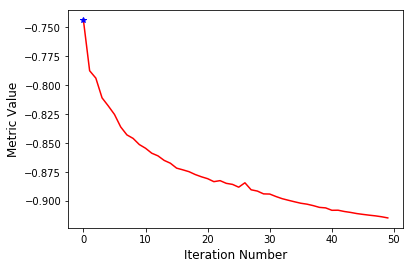

Optimizer's stopping condition, LBFGSBOptimizerv4: User requested
Final metric value: -0.9144702221770894


In [27]:
registration_method = sitk.ImageRegistrationMethod()
# Determine the number of BSpline control points using the physical spacing we want for the control grid. 
grid_physical_spacing = [10.0, 10.0, 10.0] # A control point every 10 um
image_physical_size = [size*spacing for size,spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())]
mesh_size = [int(image_size/grid_spacing + 0.5) \
             for image_size,grid_spacing in zip(image_physical_size,grid_physical_spacing)]

local_transform = sitk.BSplineTransformInitializer(image1 = fixed_image, transformDomainMeshSize = mesh_size, order=3)    
registration_method.SetInitialTransform(local_transform, inPlace = True)
registration_method.SetMovingInitialTransform(global_transform)
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsLBFGSB(gradientConvergenceTolerance=1e-5, numberOfIterations=50)

registration_method.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                              registration_callbacks.metric_update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, 
                               lambda: registration_callbacks.metric_plot_values(registration_method))
registration_method.Execute(fixed_image, moving_image)
# Need to compose the transformations after registration.
#final_transform = sitk.CompositeTransform([global_transform,local_transform]) #Works only in simpleITK 2.0
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))

#### Check composite transformation: (ffd * affine) view1 vs view0

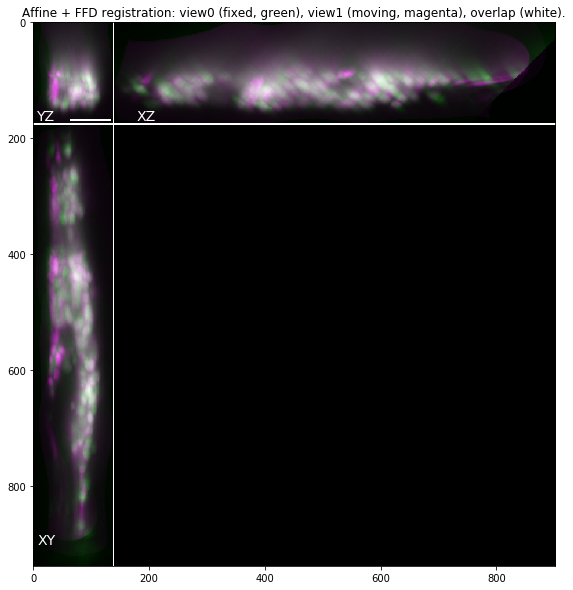

In [28]:
view1_affine_ffd = sitk.Resample(view1_affine, view0, local_transform, sitk.sitkLinear, 0.0, view0.GetPixelID())
img_merge = util.merge_images_rgb(view0, view1_affine_ffd)

fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "Affine + FFD registration: view0 (fixed, green), view1 (moving, magenta), overlap (white).", scalebar=10)

#### Check ffd vs affine difference (view1)

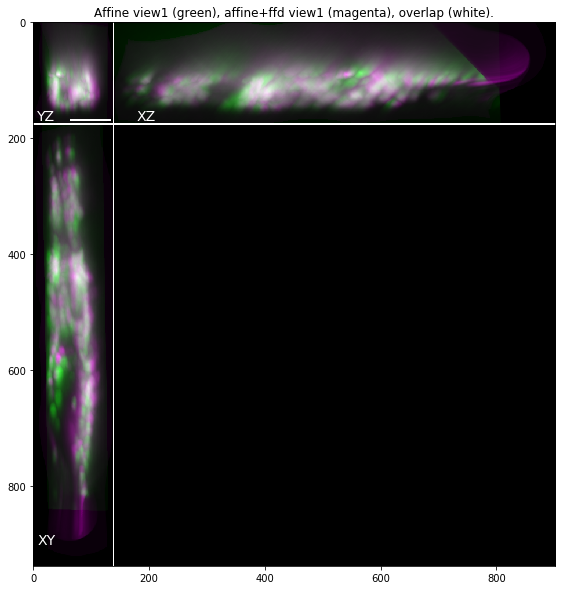

In [29]:
img_merge = util.merge_images_rgb(view1_affine, view1_affine_ffd)
fig = plt.figure(figsize=(10,10))
util.show_mips(img_merge, "Affine view1 (green), affine+ffd view1 (magenta), overlap (white).", scalebar=10)

In [31]:
util.save_transform(local_transform, os.path.normpath(dirname_data + 'transf_view1_ffd'))